# Supervised Pipeline

Removing feature: OFFEREDQUANTITY with VIF: 384376294.43507355
Removing feature: AVERAGEPRICE with VIF: 1694098.7364609067
Removing feature: GROSSAVGYIELD with VIF: 107285.64257854286
Removing feature: PURCHASEDQUANTITY with VIF: 415.5019052606394
Removing feature: SERIES with VIF: 190.0990035578509
Removing feature: ORIGINALTERMTOMATURITY with VIF: 90.94522121554313
Removing feature: DEMANDEDAMOUNT with VIF: 22.171788723896718
Removing feature: CUTOFFPRICE with VIF: 7.170536448416149
Remaining features after VIF calculation:
                 feature       VIF
0  ACTUALTERMTOMATURITY  1.903104
1                COUPON  4.074414
2   ADDITIONALPURCHASED  1.123887
3          TOTALFUNDING  3.360638
4            COVERRATIO  3.693616
5      GROSSCUTOFFYIELD  4.639008
Label Mapping: {'GOV': 0, 'GOV_INDEX': 1, 'GOV_SHORT': 2, 'GOV_VAR': 3}
Training XGBoost...
XGBoost - Cross-Validation Accuracy: 1.00


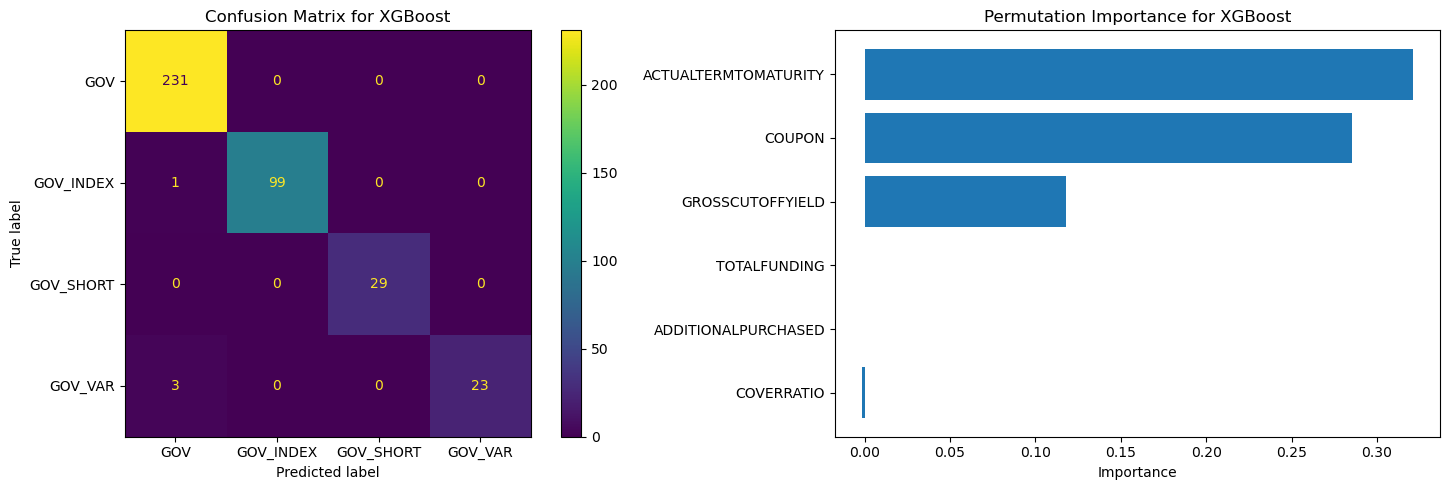

Training Random Forest...
Random Forest - Cross-Validation Accuracy: 0.99


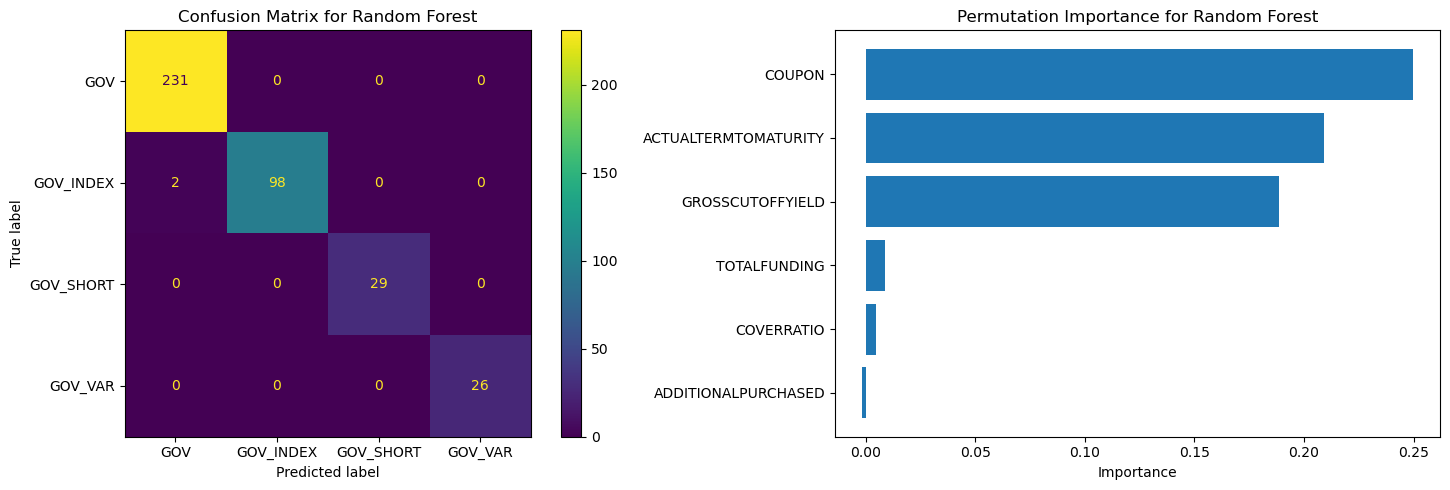

Training KNN...
KNN - Cross-Validation Accuracy: 0.90


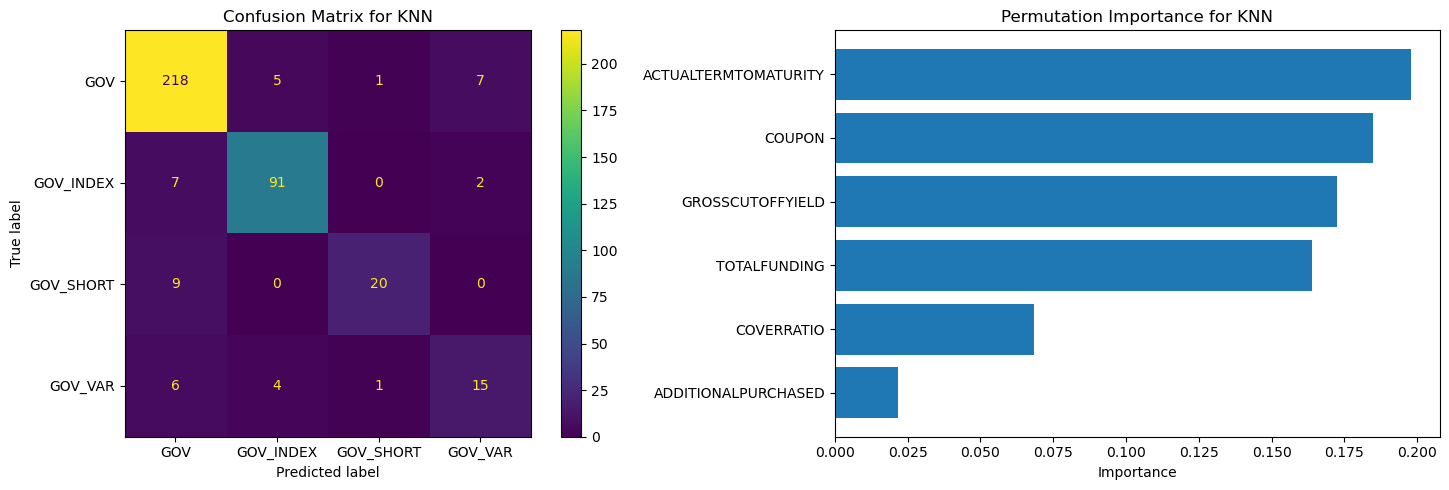

Training SVM...
SVM - Cross-Validation Accuracy: 0.80


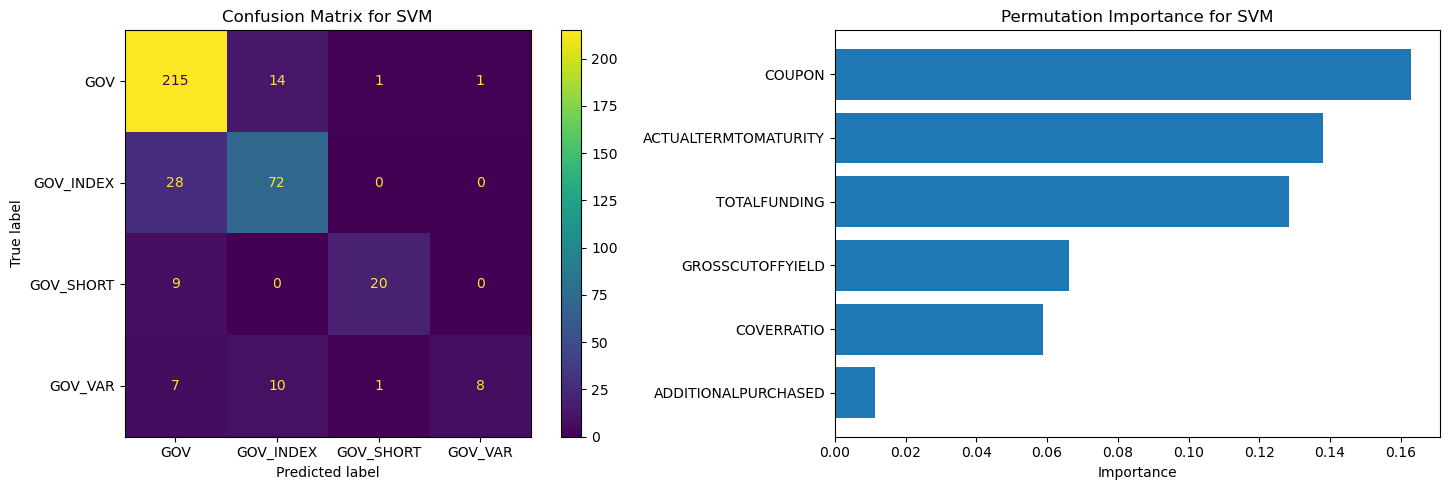

Training Logistic Regression...
Logistic Regression - Cross-Validation Accuracy: 0.76


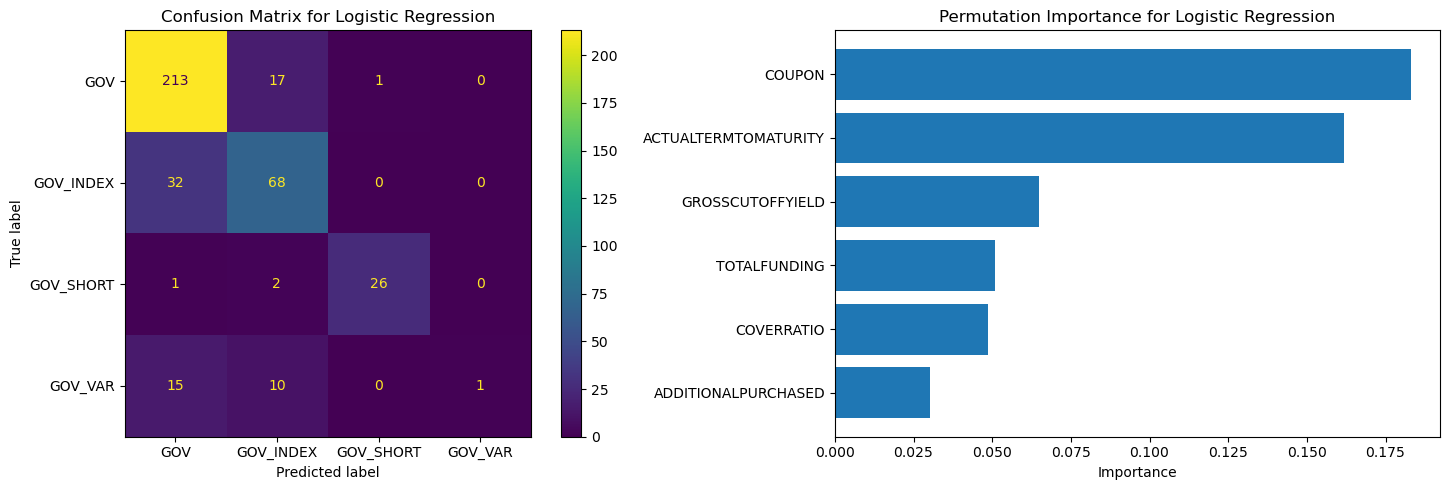


Comparison of Models:
                  Model  CV Accuracy  Test Accuracy  Precision    Recall  \
0              XGBoost     0.997411       0.989637   0.989814  0.968654   
1        Random Forest     0.990926       0.994819   0.994863  0.995000   
2                  KNN     0.898186       0.891192   0.889737  0.780075   
3                  SVM     0.803494       0.816062   0.819253  0.662021   
4  Logistic Regression     0.755492       0.797927   0.809705  0.634273   

   F1 Score  
0  0.989437  
1  0.994804  
2  0.889066  
3  0.805219  
4  0.771767  


In [715]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Function to calculate VIF and remove features with high VIF
def calculate_vif(df):
    while True:
        vif_data = pd.DataFrame()
        X = df.select_dtypes(include=['float64', 'int64'])
        vif_data["feature"] = X.columns
        vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
        max_vif = vif_data["VIF"].max()
        if max_vif <= 5:  # Stop if all VIF values are <= 5
            break
        feature_to_drop = vif_data.loc[vif_data['VIF'].idxmax(), 'feature']
        print(f"Removing feature: {feature_to_drop} with VIF: {max_vif}")
        df = df.drop(columns=[feature_to_drop])
    print("Remaining features after VIF calculation:\n", vif_data)
    return df

# Load dataset
df = pd.read_csv('file.csv', encoding='windows-1255')

# Remove date columns
date_columns = df.select_dtypes(include=['object']).columns[
    df.select_dtypes(include=['object']).columns.str.contains('date', case=False, na=False)
]
df = df.drop(columns=date_columns)

# Replace values in 'BONDS'
replacements = {
    'ממשלתית': 'GOV',
    'ממשלתית בריבית משתנה': 'GOV_VAR',
    'ממשלתית צמודה': 'GOV_INDEX',
    'ממשלתית קצרה': 'GOV_SHORT'
}
df['BONDS'] = df['BONDS'].map(replacements)

# Separate features and target
X = df.drop(columns=['BONDS'])
y = df['BONDS']

# Apply VIF calculation to remove features with multicollinearity
X = calculate_vif(X)

# Encode the target column
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Save the mapping of classes
label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print("Label Mapping:", label_mapping)

# Preprocessing for numerical data only
preprocessor = StandardScaler()

# Define models
models = {
    'XGBoost': XGBClassifier(objective="multi:softprob", use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'SVM': svm.SVC(kernel='rbf', probability=True),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
}

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Store results
results = []

# Loop through each model
for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    # Create pipeline
    pipeline = Pipeline(steps=[
        ('scaler', preprocessor),
        ('classifier', model)
    ])
    
    # Cross-validation (10-Fold)
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy')
    mean_cv_score = np.mean(cv_scores)
    print(f"{model_name} - Cross-Validation Accuracy: {mean_cv_score:.2f}")
    
    # Train the pipeline
    pipeline.fit(X_train, y_train)
    
    # Predict
    y_pred = pipeline.predict(X_test)
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Plot Confusion Matrix and Permutation Importance side by side
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=encoder.classes_).plot(ax=ax[0], cmap='viridis')
    ax[0].set_title(f"Confusion Matrix for {model_name}")
    
    # Permutation Importance
    perm_importance = permutation_importance(pipeline, X_test, y_test, n_repeats=10, random_state=42)
    sorted_idx = perm_importance.importances_mean.argsort()
    ax[1].barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
    ax[1].set_title(f"Permutation Importance for {model_name}")
    ax[1].set_xlabel("Importance")
    
    plt.tight_layout()
    plt.show()
    
    # Save results
    results.append({
        'Model': model_name,
        'CV Accuracy': mean_cv_score,
        'Test Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

# Display results
results_df = pd.DataFrame(results)
print("\nComparison of Models:\n", results_df)


# T-SNE & PCA

In [717]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import plotly.express as px

# Example dataset (replace df with your DataFrame)
data_scaled = df.copy()
X = data_scaled.drop(columns=['BONDS'])
y = data_scaled['BONDS']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define columns to scale
col_to_scale = X_train.columns

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[col_to_scale])

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X_train_scaled) - 1))
X_train_tsne = tsne.fit_transform(X_train_scaled)

# Create a DataFrame for t-SNE visualization
tsne_df = pd.DataFrame({
    "First t-SNE": X_train_tsne[:, 0],
    "Second t-SNE": X_train_tsne[:, 1],
    "BONDS": y_train.values
})

# Plot the t-SNE results
tsne_fig = px.scatter(
    tsne_df,
    x="First t-SNE",
    y="Second t-SNE",
    color="BONDS",
    title="t-SNE Visualization of BONDS Dataset"
)

tsne_fig.update_layout(
    xaxis_title="First t-SNE",
    yaxis_title="Second t-SNE",
)

# Apply PCA
pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)

# Create a DataFrame for PCA visualization
pca_df = pd.DataFrame({
    "First PCA": X_train_pca[:, 0],
    "Second PCA": X_train_pca[:, 1],
    "BONDS": y_train.values
})

# Plot the PCA results
pca_fig = px.scatter(
    pca_df,
    x="First PCA",
    y="Second PCA",
    color="BONDS",
    title="PCA Visualization of BONDS Dataset"
)

pca_fig.update_layout(
    xaxis_title="First PCA",
    yaxis_title="Second PCA",
)

# Show both visualizations
tsne_fig.show()
pca_fig.show()

# Unsupervised Analysis

In [719]:
from sklearn.preprocessing import MinMaxScaler
new_data = data_scaled.drop(columns=['BONDS'])
scaler = MinMaxScaler()
unsupervise_data_scaled = pd.DataFrame(scaler.fit_transform(new_data), columns=new_data.columns)
unsupervise_data_scaled

,SERIES,ACTUALTERMTOMATURITY,ORIGINALTERMTOMATURITY,COUPON,OFFEREDQUANTITY,PURCHASEDQUANTITY,ADDITIONALPURCHASED,AVERAGEPRICE,CUTOFFPRICE,TOTALFUNDING,DEMANDEDAMOUNT,COVERRATIO,GROSSAVGYIELD,GROSSCUTOFFYIELD
0,0.670637,0.895765,1.000000,0.509091,0.052739,0.070287,1.000000,0.062549,0.064520,0.049275,0.014960,0.10,0.909244,0.907718
1,0.879293,0.322476,0.333333,0.727273,0.069928,0.090749,1.000000,0.380171,0.381474,0.090487,0.019315,0.10,0.835294,0.833893
2,0.893546,0.078176,0.100000,0.681818,0.060367,0.008778,0.724805,0.402795,0.404050,0.008945,0.001868,0.01,0.793277,0.791946
3,1.000000,0.140065,0.133333,0.836364,0.076794,0.096319,0.989851,0.421315,0.422532,0.099739,0.020500,0.10,0.810084,0.808725
4,0.822077,0.110749,0.133333,0.200000,0.063063,0.082577,1.000000,0.430742,0.431939,0.086233,0.017575,0.10,0.379832,0.379195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1923,0.187386,0.192182,0.266667,0.023636,0.022428,0.028030,0.975926,0.412332,0.413568,0.028782,0.005966,0.08,0.075630,0.075503
1924,0.339090,0.110749,0.133333,0.272727,0.120785,0.151290,1.000000,0.471110,0.472001,0.163677,0.120849,0.38,0.092437,0.092282
1925,0.373790,0.068404,0.066667,0.136364,0.120785,0.151290,1.000000,0.438061,0.439132,0.159016,0.173292,0.54,0.072269,0.072148
1926,0.361435,0.289902,0.300000,0.090909,0.120785,0.151290,1.000000,0.553510,0.554228,0.175299,0.169040,0.52,0.025210,0.025168


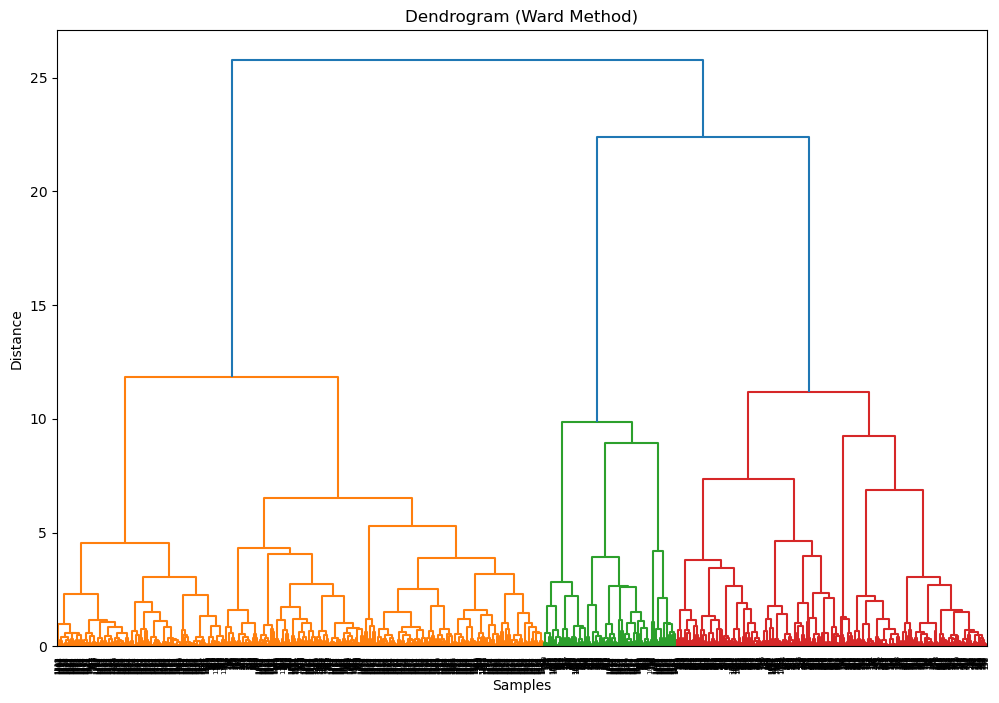

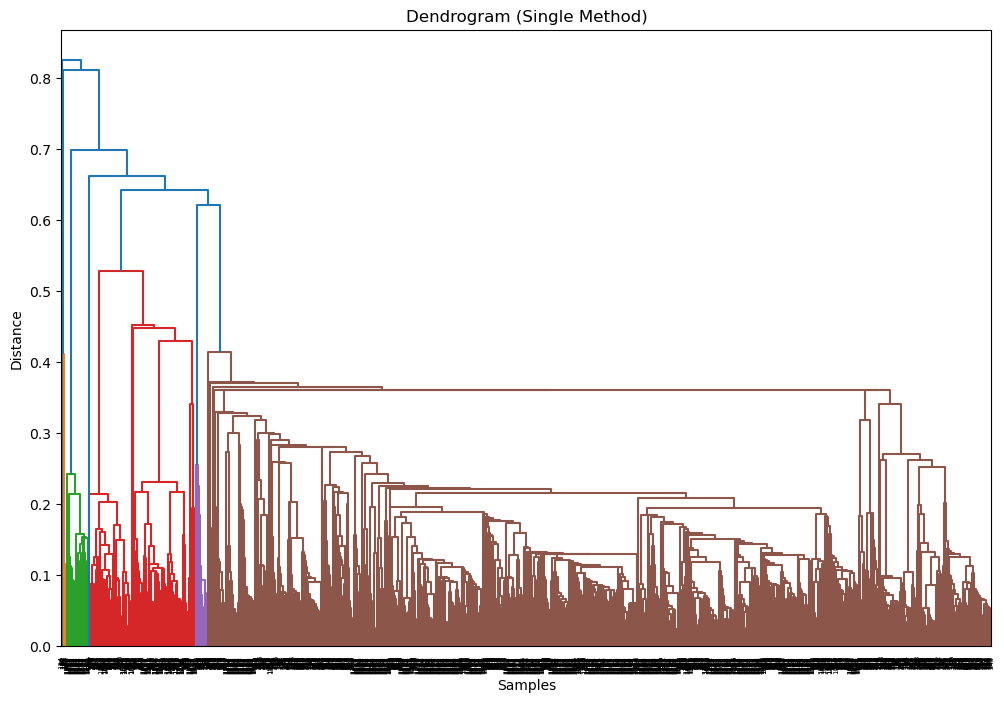

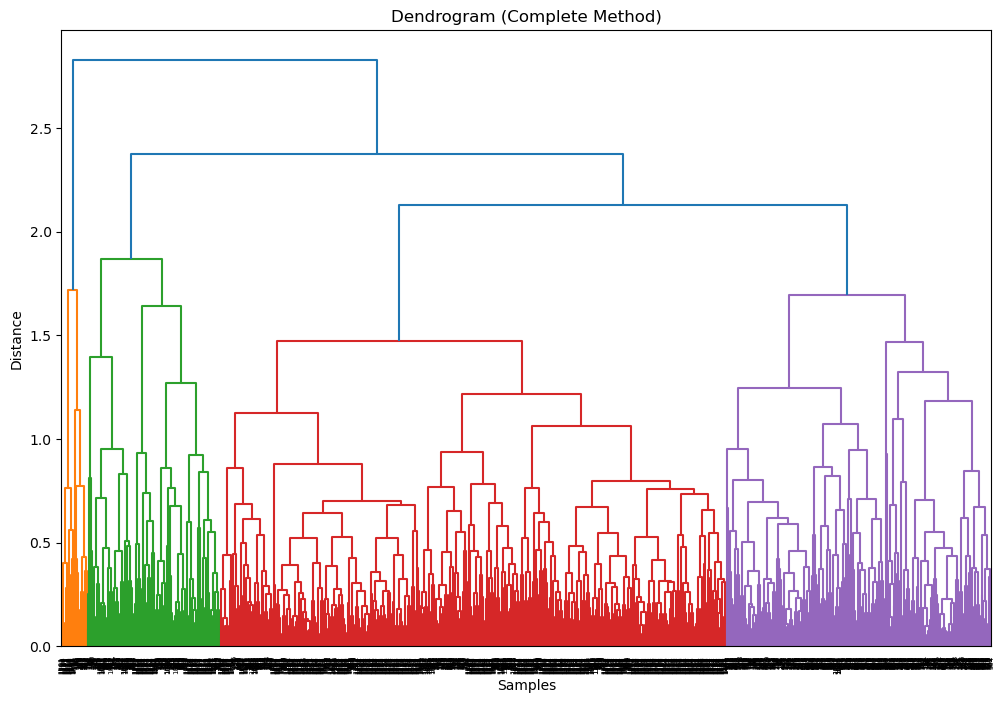

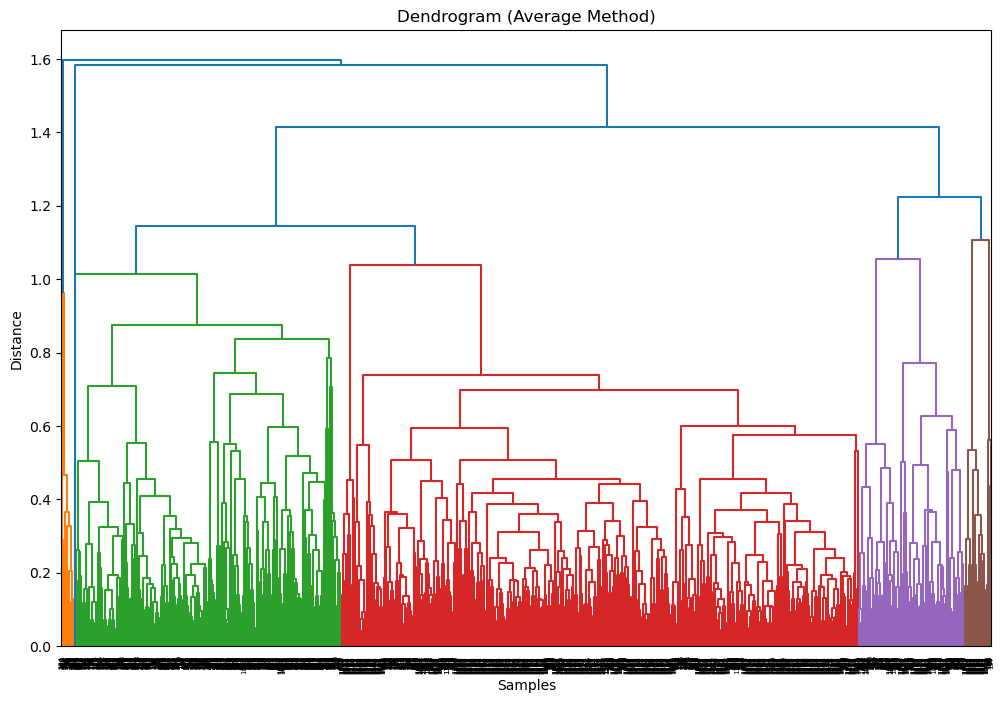

In [720]:
# Function to plot dendrograms

def plot_dendrogram(unsupervise_data, methods=['ward', 'single', 'complete', 'average']):
    for method in methods:
        plt.figure(figsize=(12, 8))
        dendrogram = sch.dendrogram(sch.linkage(unsupervise_data, method=method))
        plt.title(f'Dendrogram ({method.capitalize()} Method)')
        plt.xlabel('Samples')
        plt.ylabel('Distance')
        plt.show()


# Plot dendrograms with all methods
plot_dendrogram(unsupervise_data_scaled)

In [721]:
#Perform hierarchical clustering
hc_ward = sch.linkage(unsupervise_data_scaled, method="ward", metric="euclidean")

Text(0, 0.5, 'Variation in cluster distance')

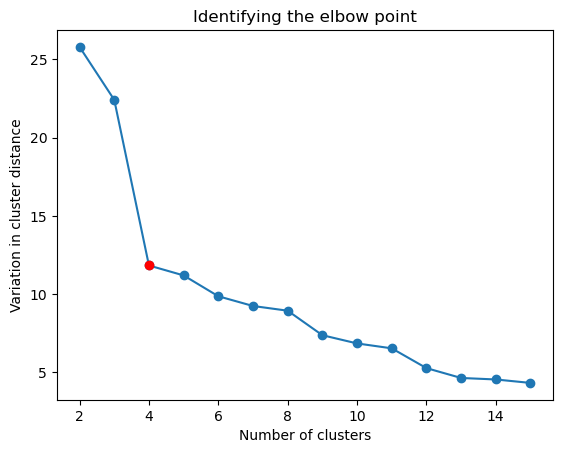

In [722]:
#Plot the elbow point
distances = hc_ward[-14:, 2]
num_clusters = np.arange(len(distances) + 1, 1, -1)
plt.plot(num_clusters, distances, marker='o')
plt.plot(4, hc_ward[-3,2], color='red', marker='o')
plt.title('Identifying the elbow point')
plt.xlabel('Number of clusters')
plt.ylabel('Variation in cluster distance')

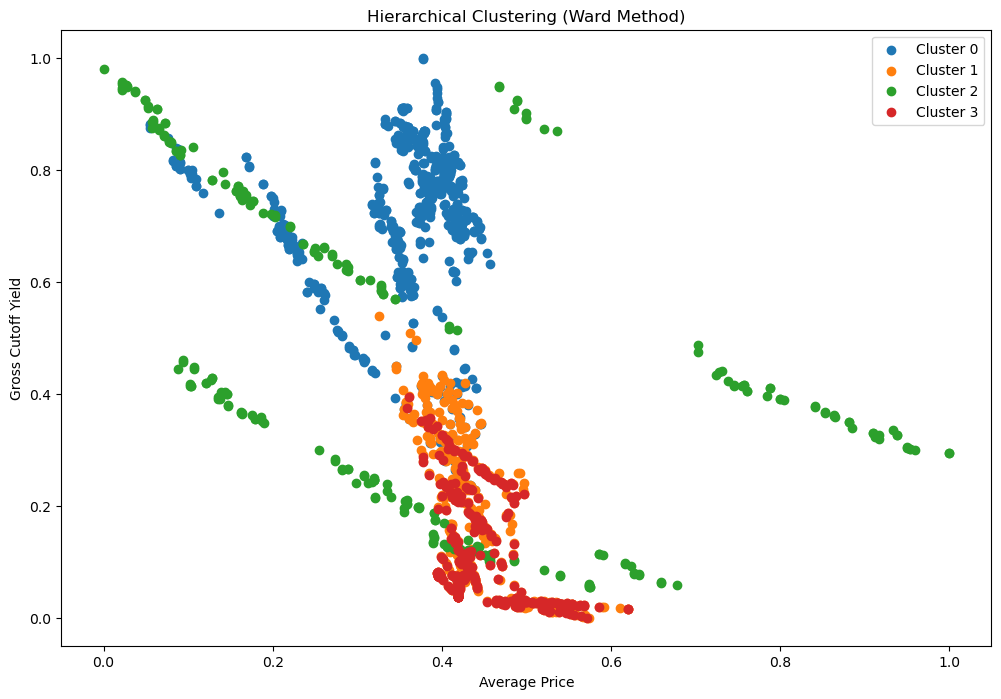

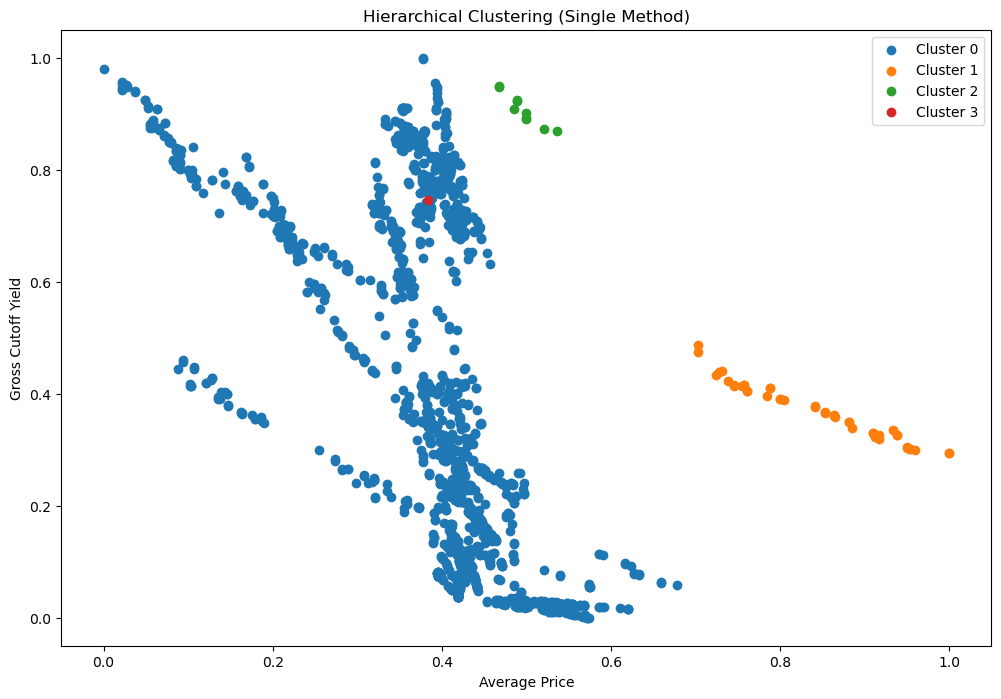

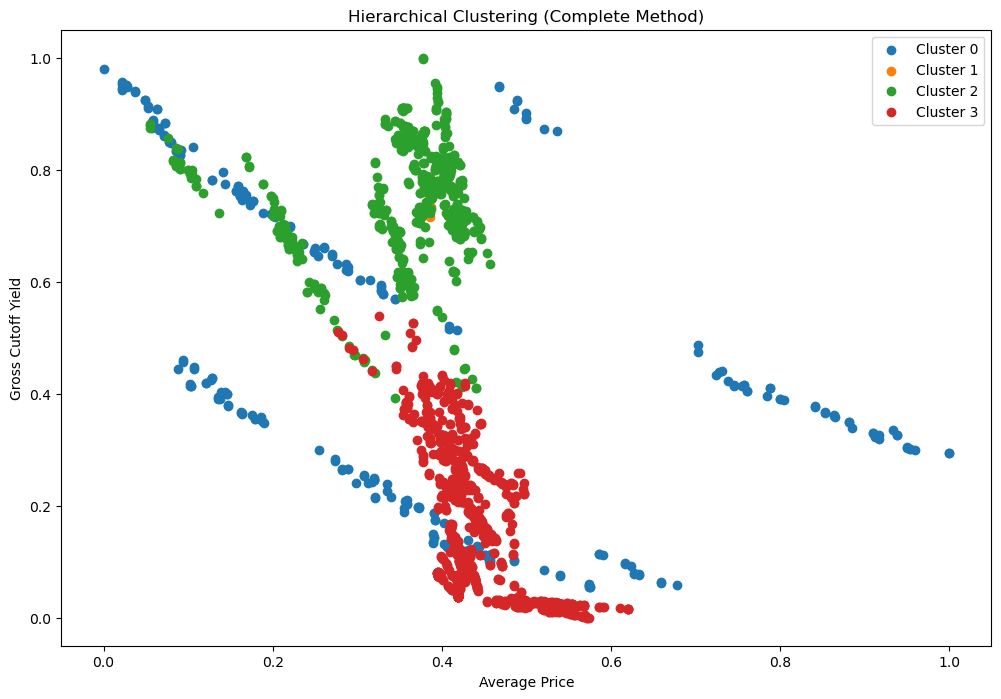

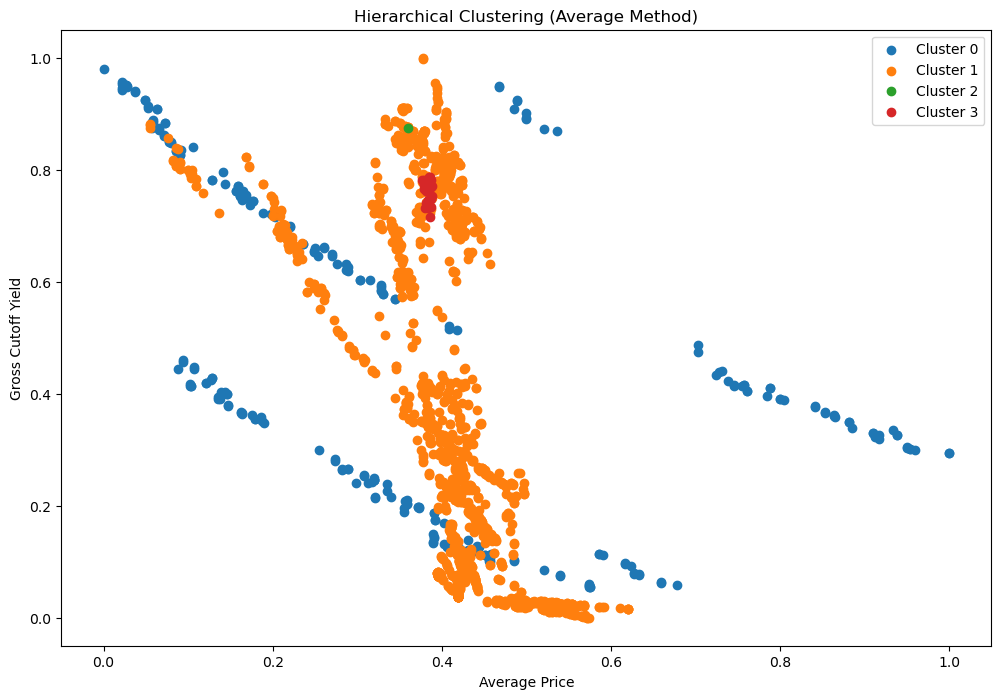

In [723]:
# Function to perform clustering and visualization
def hierarchical_clustering(data, n_clusters=4, methods=['ward', 'single', 'complete', 'average']):
    for method in methods:
        hc = AgglomerativeClustering(n_clusters=n_clusters, linkage=method)
        y_pred = hc.fit_predict(data)
        
        clustered_data = data.copy()
        clustered_data['cluster'] = y_pred

        plt.figure(figsize=(12, 8))
        for cluster in range(n_clusters):
            plt.scatter(
                clustered_data.loc[clustered_data['cluster'] == cluster, 'AVERAGEPRICE'],
                clustered_data.loc[clustered_data['cluster'] == cluster, 'GROSSCUTOFFYIELD'],
                label=f'Cluster {cluster}'
            )
        plt.title(f'Hierarchical Clustering ({method.capitalize()} Method)')
        plt.xlabel('Average Price')
        plt.ylabel('Gross Cutoff Yield')
        plt.legend()
        plt.show()

# Perform clustering and visualization
hierarchical_clustering(unsupervise_data_scaled)

# K-Means

In [725]:
from sklearn.cluster import KMeans

In [726]:
wcss = []
cl_num=len(unsupervise_data_scaled.columns)
for i in range (1,cl_num):
    kmeans= KMeans(i)
    kmeans.fit(unsupervise_data_scaled)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)

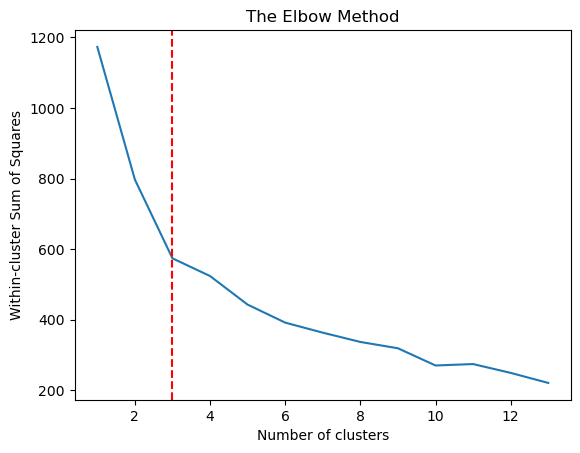

In [727]:
number_clusters = range(1,cl_num)
plt.plot(number_clusters, wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster Sum of Squares')
optimal_k = 3
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal k={optimal_k}')

For n_clusters = 2, the average silhouette_score is : 0.34098239748666487
For n_clusters = 3, the average silhouette_score is : 0.3865496929713762
For n_clusters = 4, the average silhouette_score is : 0.3314318946151291
For n_clusters = 5, the average silhouette_score is : 0.29514868731357113
For n_clusters = 6, the average silhouette_score is : 0.30713343913455565


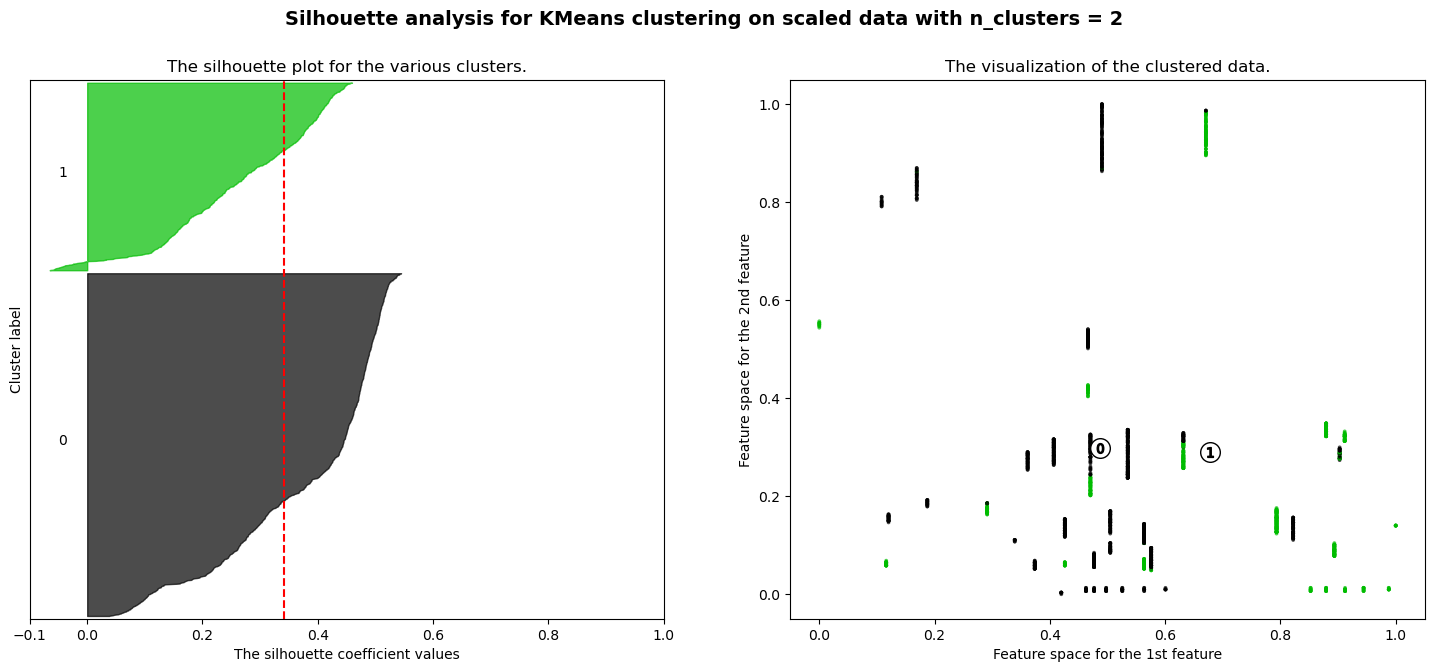

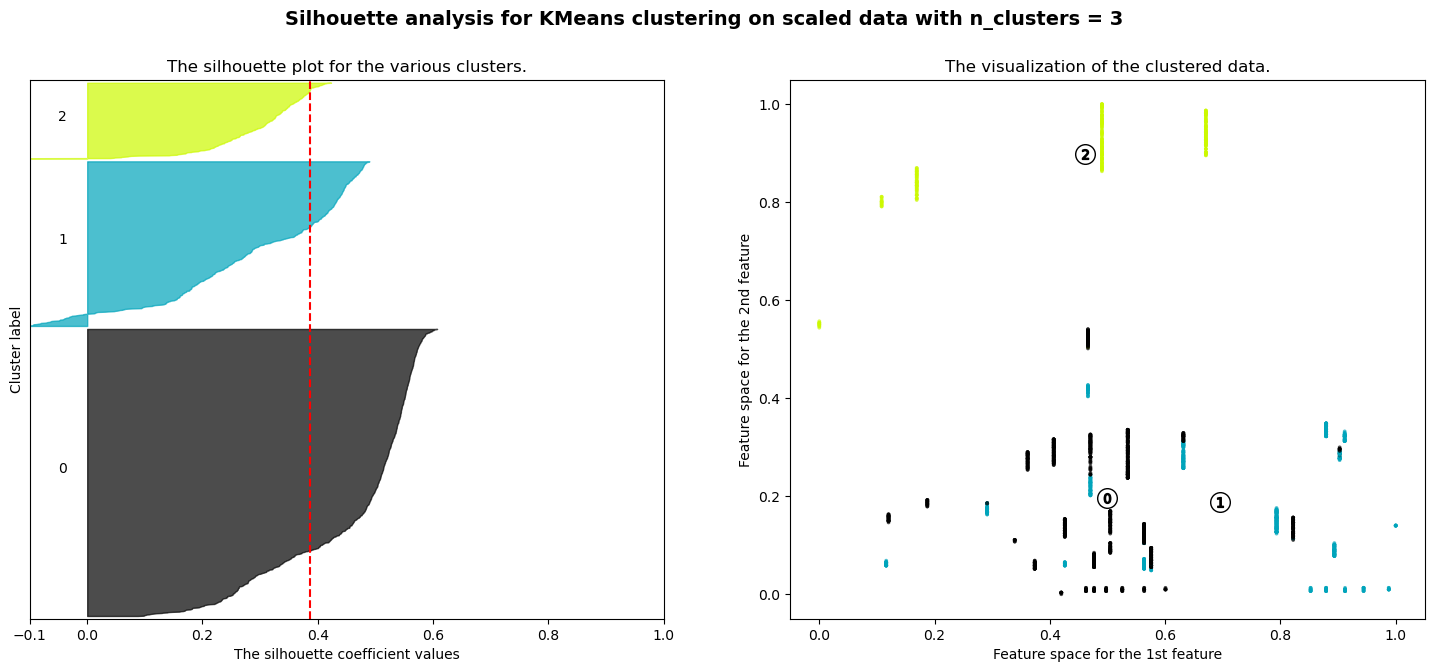

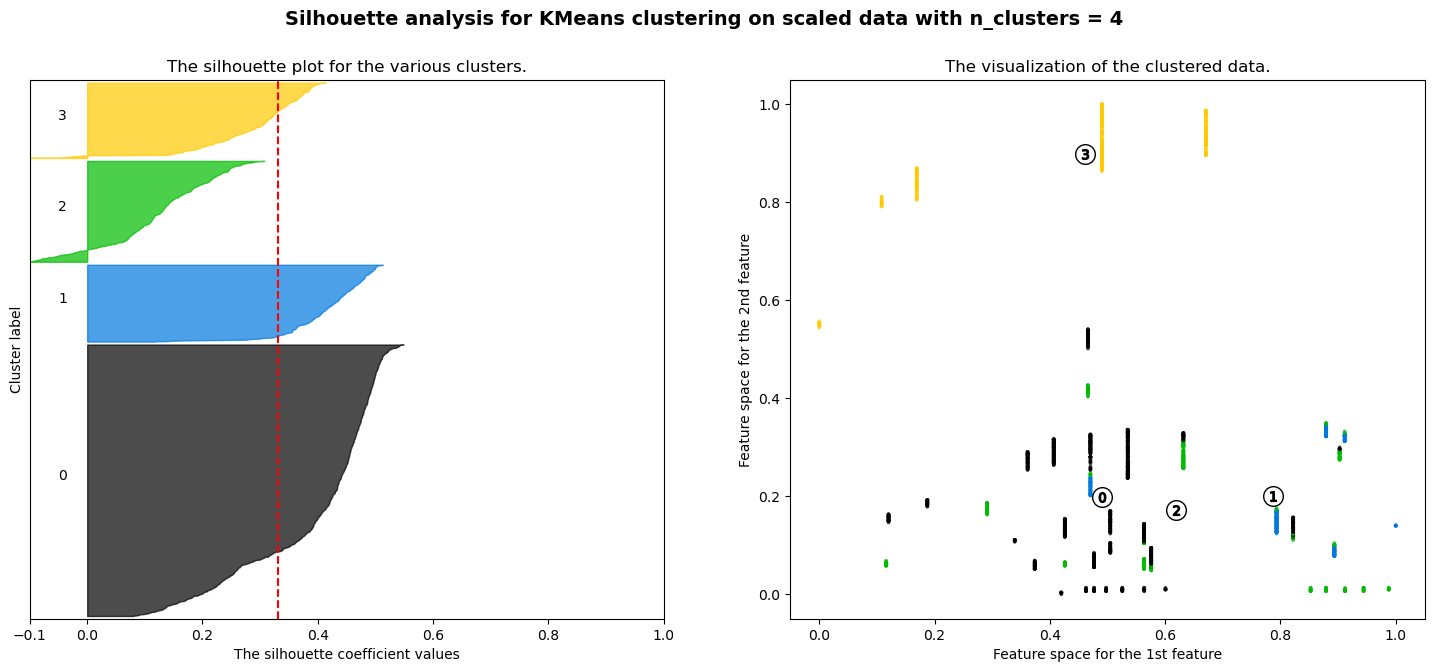

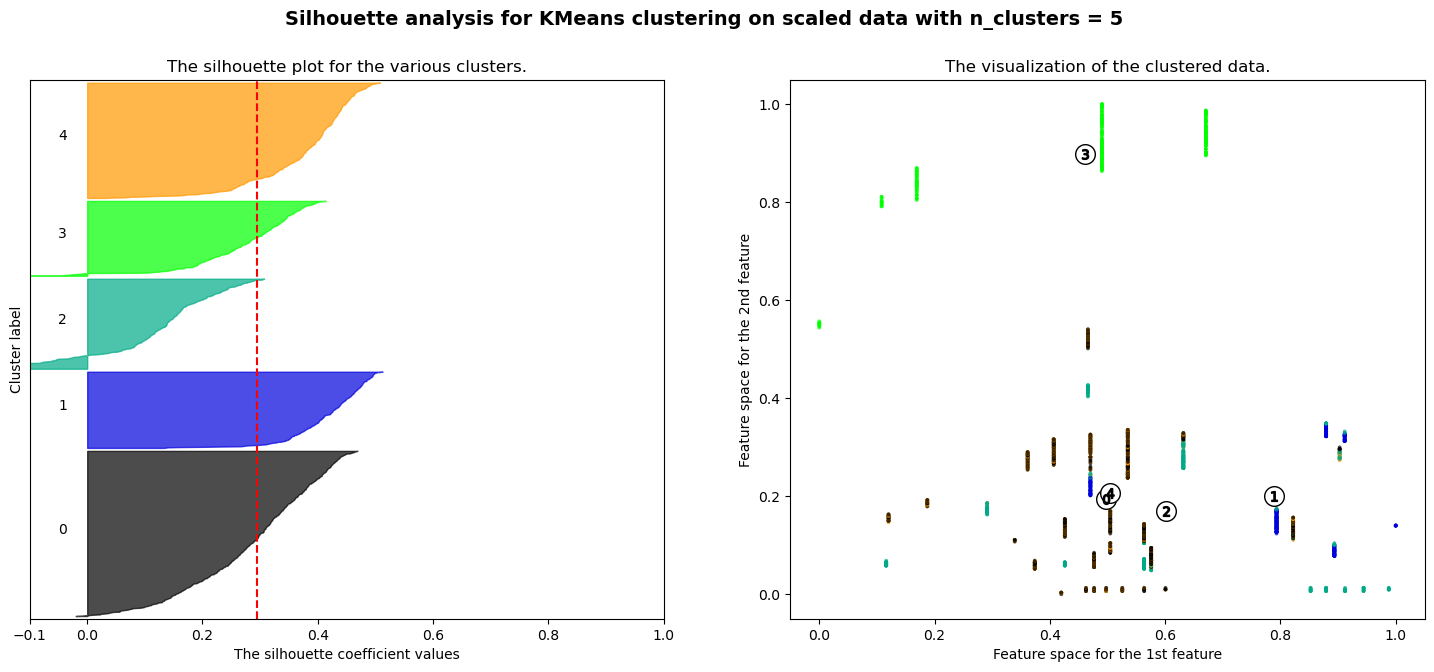

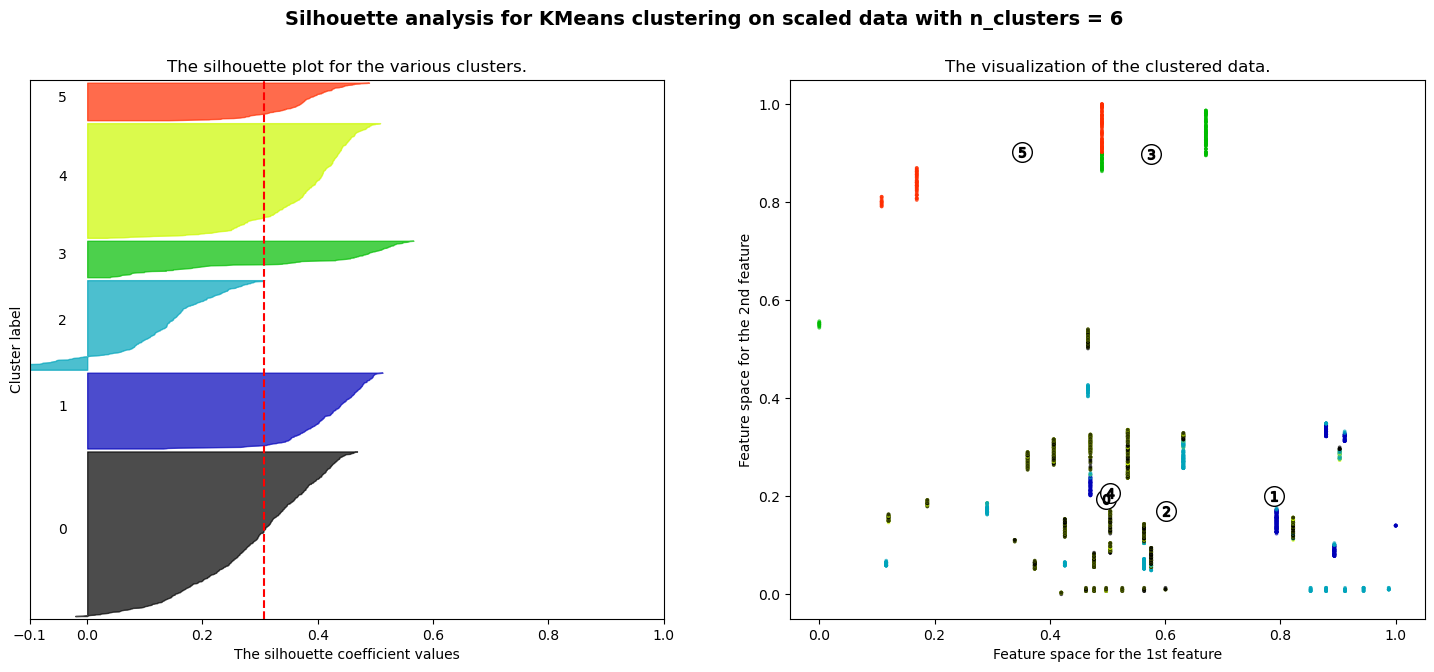

In [728]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# Assuming unsupervise_data_scaled is a DataFrame
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(unsupervise_data_scaled) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(unsupervise_data_scaled)

    # Compute the average silhouette score
    silhouette_avg = silhouette_score(unsupervise_data_scaled, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(unsupervise_data_scaled, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate and sort silhouette scores for samples in the cluster
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  # Move to the next cluster

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        unsupervise_data_scaled.iloc[:, 0].values,  # Access the first feature
        unsupervise_data_scaled.iloc[:, 1].values,  # Access the second feature
        marker=".", 
        s=30, 
        lw=0, 
        alpha=0.7, 
        c=colors, 
        edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker=f"${i}$", alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        f"Silhouette analysis for KMeans clustering on scaled data with n_clusters = {n_clusters}",
        fontsize=14,
        fontweight="bold",
    )

plt.show()


In [729]:
k_means=KMeans(n_clusters=3,random_state=42)
k_means.fit(unsupervise_data)

KMeans(n_clusters=3, random_state=42)

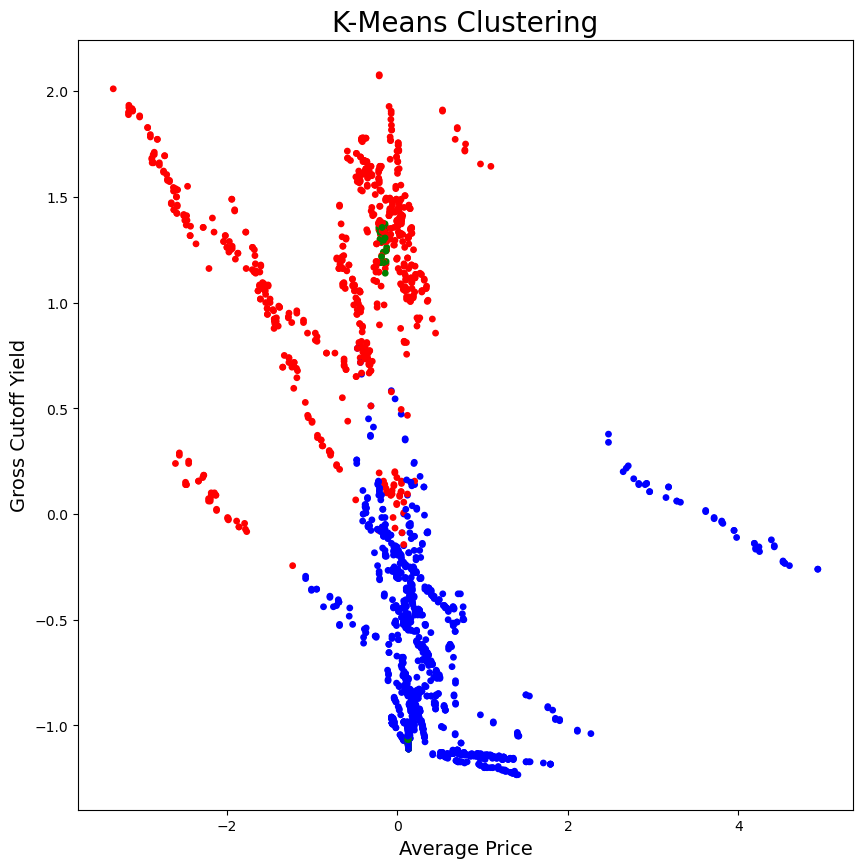

In [730]:
import matplotlib.colors
k_means_data = unsupervise_data_scaled.copy() 
k_means_data['KMeans_labels']=k_means.labels_

# Plotting resulting clusters
colors=['red','blue','green']
plt.figure(figsize=(10,10))
plt.scatter(unsupervise_data['AVERAGEPRICE'],unsupervise_data['GROSSCUTOFFYIELD'],c=k_means_data['KMeans_labels'],cmap=matplotlib.colors.ListedColormap(colors),s=15)
plt.title('K-Means Clustering',fontsize=20)
plt.xlabel('Average Price',fontsize=14)
plt.ylabel('Gross Cutoff Yield',fontsize=14)
plt.show()

# DBSCAN

In [732]:
from sklearn.cluster import DBSCAN
dbscan_data = unsupervise_data_scaled.copy() # copy data
dbscan_data.head()
dbscan=DBSCAN()
dbscan_labels = dbscan.fit_predict(dbscan_data)
dbscan_data['DBSCAN_labels'] = dbscan_labels

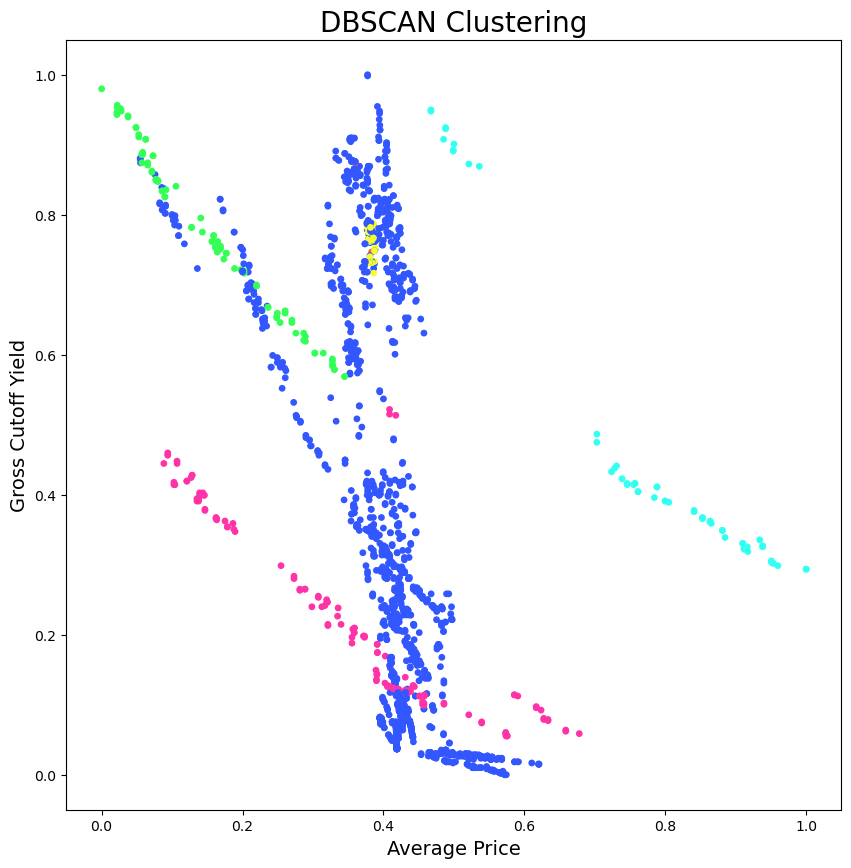

In [771]:
colors = ['#FF5733', '#33FF57', '#3357FF', '#F3FF33', '#FF33A8', '#33FFF3']
plt.figure(figsize=(10,10)) 
plt.scatter(dbscan_data['AVERAGEPRICE'],dbscan_data['GROSSCUTOFFYIELD'],c=dbscan_data['DBSCAN_labels'],cmap=matplotlib.colors.ListedColormap(colors),s=15) 
plt.title('DBSCAN Clustering',fontsize=20)
plt.xlabel('Average Price',fontsize=14)
plt.ylabel('Gross Cutoff Yield',fontsize=14)
plt.show()

In [773]:
from sklearn.metrics import silhouette_score

kmeans_silhouette = silhouette_score(k_means_data, k_means.labels_)
hc_silhouette = silhouette_score(X_pc_hc, y_pc_hc)
if len(set(dbscan_labels)) > 1:  # Ensure more than one cluster exists
    dbscan_silhouette = silhouette_score(dbscan_data[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])
else:
    dbscan_silhouette = "Not Applicable (only noise or one cluster)"
    
print(f"K-Means Silhouette Score: {kmeans_silhouette}")
print(f"Hierarchical Clustering Silhouette Score: {hc_silhouette}")
print(f"DBSCAN Silhouette Score: {dbscan_silhouette}")

K-Means Silhouette Score: 0.49545816566544704
Hierarchical Clustering Silhouette Score: 0.42948020278493465
DBSCAN Silhouette Score: 0.5232128996971228


In [775]:
noise_points = dbscan_data[dbscan_labels == -1]
print(noise_points.describe())

         SERIES  ACTUALTERMTOMATURITY  ORIGINALTERMTOMATURITY    COUPON  \
count  2.000000              2.000000                2.000000  2.000000   
mean   0.927851              0.161238                0.166667  0.379091   
std    0.023203              0.214205                0.235702  0.536116   
min    0.911444              0.009772                0.000000  0.000000   
25%    0.919648              0.085505                0.083333  0.189545   
50%    0.927851              0.161238                0.166667  0.379091   
75%    0.936055              0.236971                0.250000  0.568636   
max    0.944258              0.312704                0.333333  0.758182   

       OFFEREDQUANTITY  PURCHASEDQUANTITY  ADDITIONALPURCHASED  AVERAGEPRICE  \
count         2.000000           2.000000             2.000000      2.000000   
mean          0.625210           0.524549             0.114114      0.371631   
std           0.530033           0.672389             0.161381      0.016468   
min 

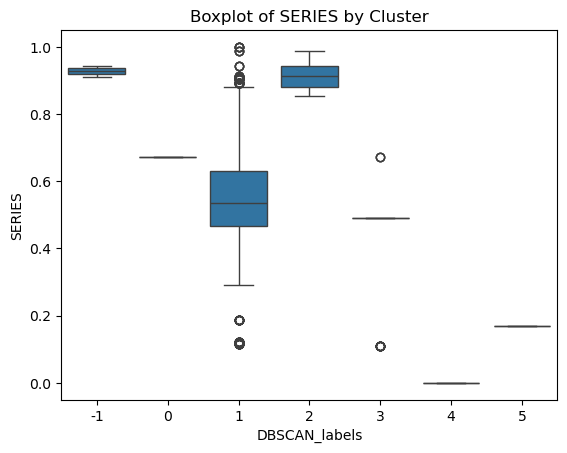

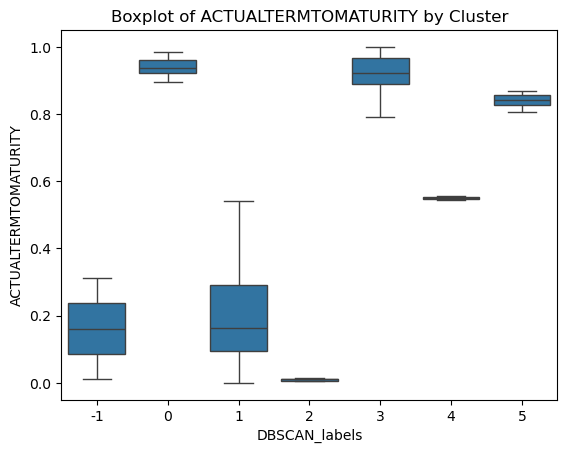

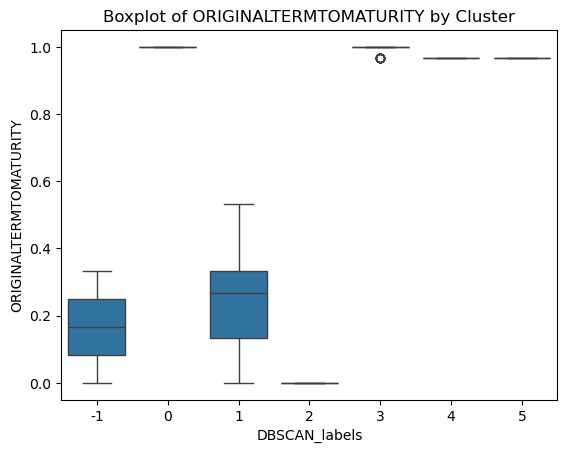

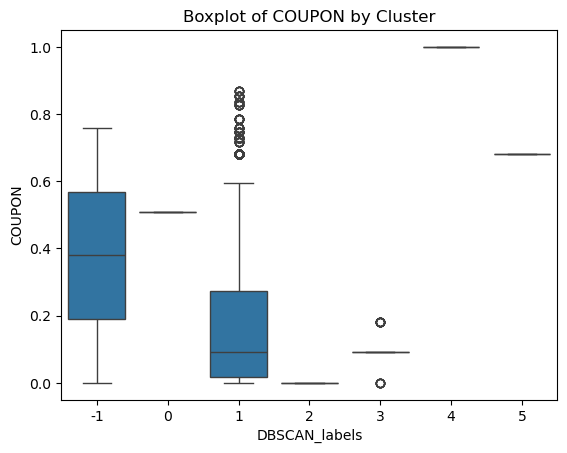

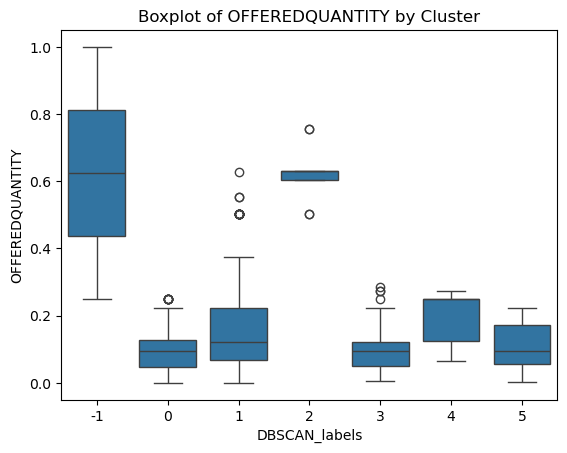

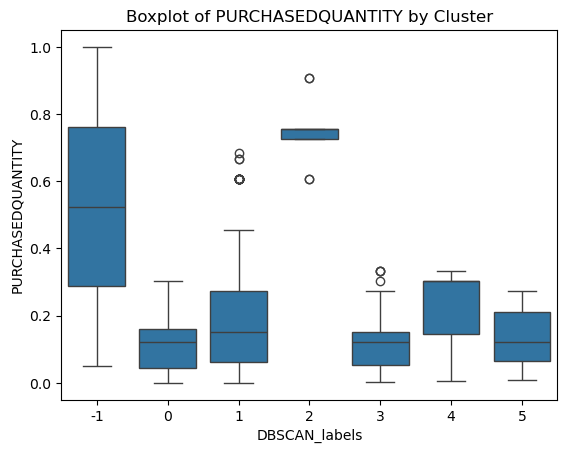

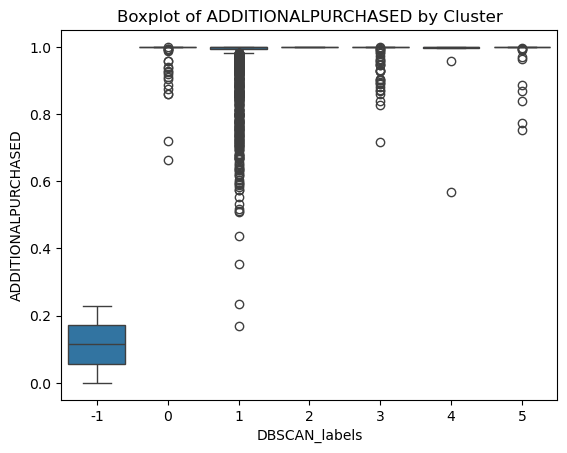

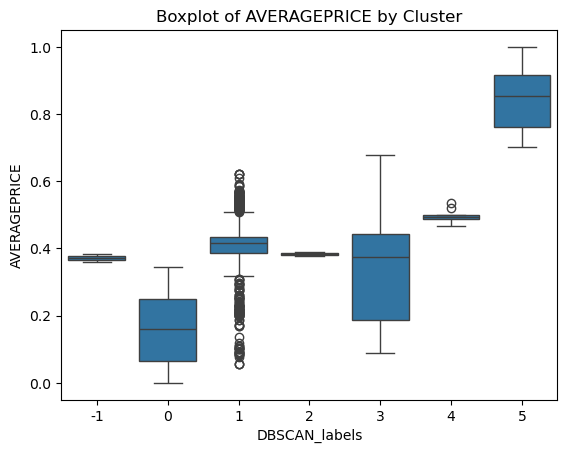

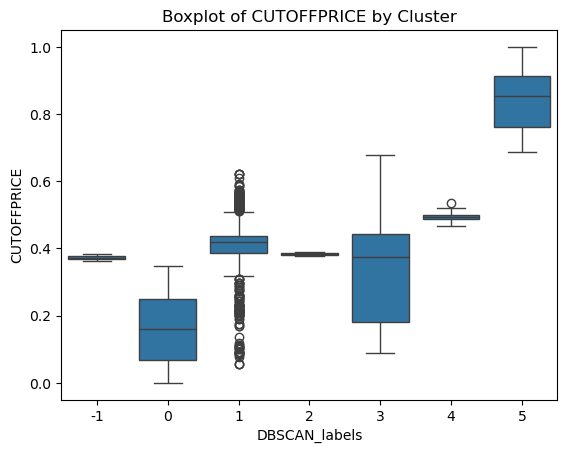

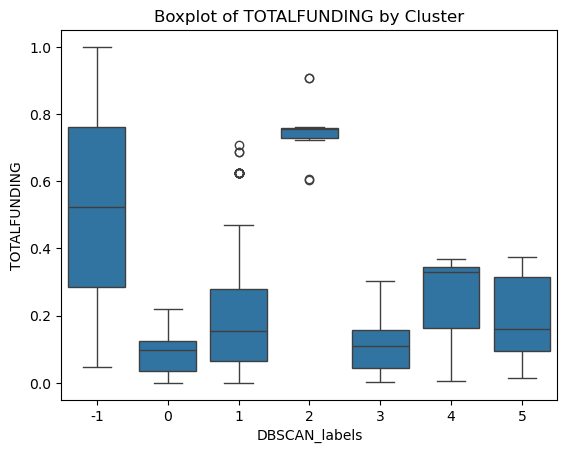

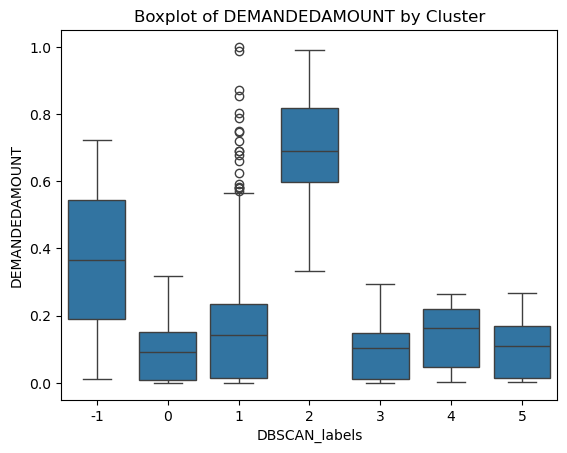

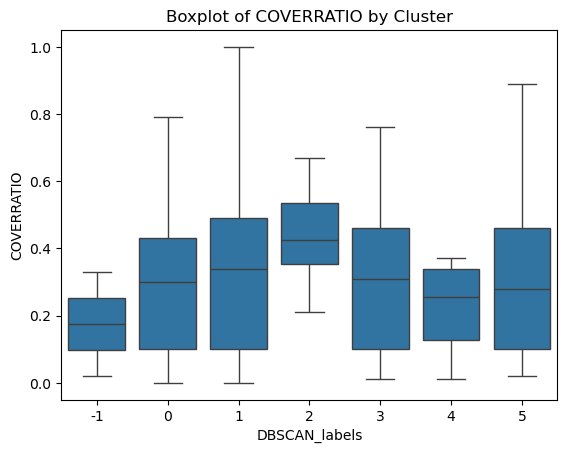

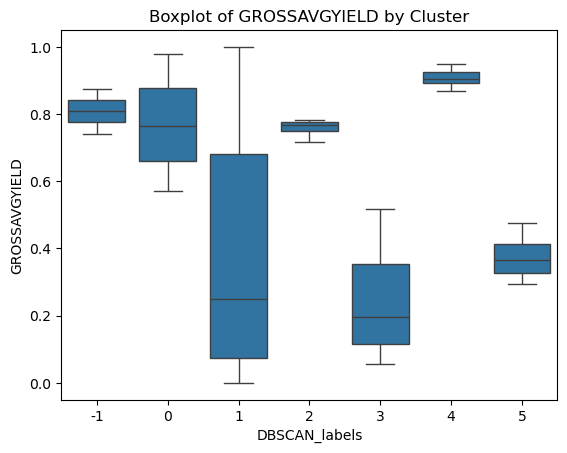

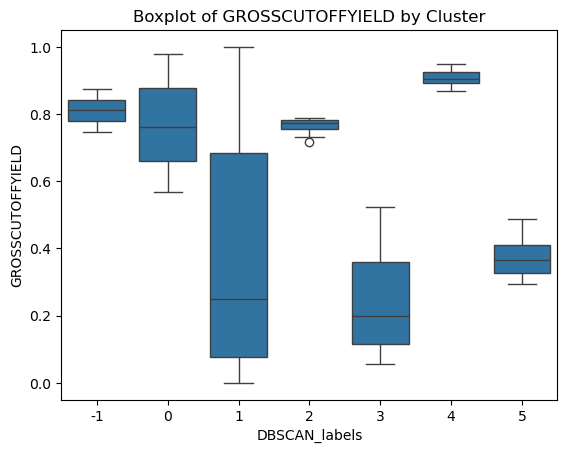

In [797]:
import seaborn as sns

for column in dbscan_data.columns:
    if column != 'DBSCAN_labels':
        sns.boxplot(x='DBSCAN_labels', y=column, data=dbscan_data)
        plt.title(f"Boxplot of {column} by Cluster")
        plt.show()

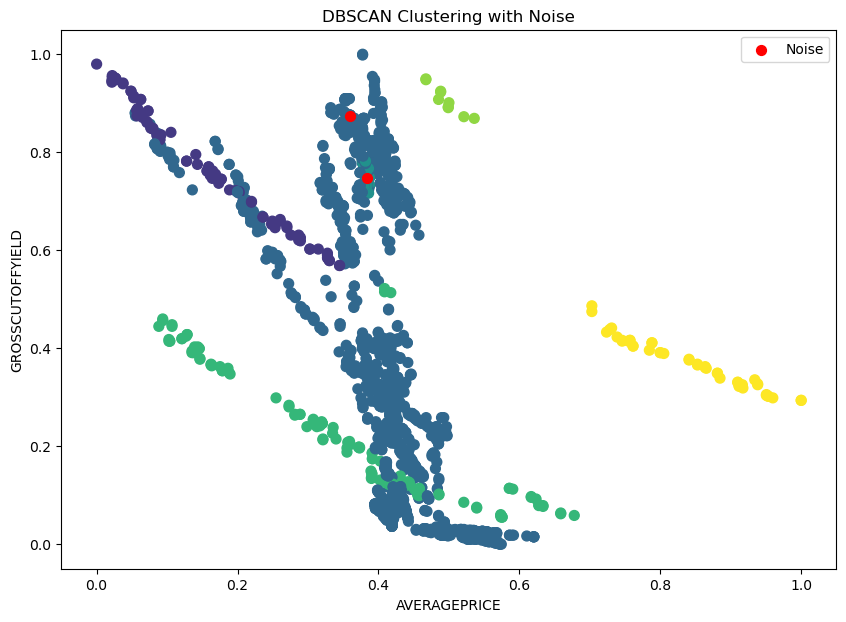

In [777]:
import matplotlib.pyplot as plt

# Visualize clusters and noise
plt.figure(figsize=(10, 7))
plt.scatter(
    dbscan_data['AVERAGEPRICE'], 
    dbscan_data['GROSSCUTOFFYIELD'], 
    c=dbscan_labels, cmap='viridis', s=50
)
plt.scatter(
    dbscan_data[dbscan_labels == -1]['AVERAGEPRICE'],
    dbscan_data[dbscan_labels == -1]['GROSSCUTOFFYIELD'],
    c='red', label='Noise', s=50
)
plt.title("DBSCAN Clustering with Noise")
plt.xlabel("AVERAGEPRICE")
plt.ylabel("GROSSCUTOFFYIELD")
plt.legend()
plt.show()


# עבודה שוטפת עם המאגר בגיטהאב
### עדכון שינויים:

In [779]:
!git add "Data Mining Supervised & Unsupervised 2025.ipynb"
!git commit -m "Improvements"
!git push origin main
!git push --set-upstream origin main

[main d377900] Improvements
 1 file changed, 132 insertions(+), 114 deletions(-)


To https://github.com/DorNatan/data-mining-project-2025.git
   009fbb1..d377900  main -> main


branch 'main' set up to track 'origin/main'.


Everything up-to-date


In [781]:
!git add -u

In [783]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
